# Project III - Home Credit Default Risk

In [1]:
import pandas as pd
import numpy as np
import scipy
import IPython.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import time
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

In [2]:
test = pd.read_csv("application_test.csv") 
train = pd.read_csv("application_train.csv") 

In [3]:
# create a copy of the original train dataframe
X_train = train.copy()
# create a copy of the original test dataframe
X_test = test.copy()

In [4]:
# to see all the columns
pd.options.display.max_columns = None

### Exploratory Data Analysis

**Dataset Basics**

In [5]:
# shape of the train and test dataset
X_train.shape, X_test.shape

((307511, 122), (48744, 121))

In [6]:
# columns of the train dataset
X_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [7]:
# info about dataset
display(X_train.head().transpose())
pd.set_option('display.max_rows', None)
pd.reset_option("max_rows")

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_MON,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_QRT,0.0,0.0,0.0,NaN,0.0


4- Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

In [8]:
# TARGET: (0) paid loans
# TARGET: (1) late payment

In [9]:
# target total
target_total = X_train["TARGET"].count()
print(f"Target total: {target_total}")

Target total: 307511


In [10]:
# target: total 0 & total 1
total_target_0 = X_train["TARGET"].value_counts()[0]
total_target_1 = X_train["TARGET"].value_counts()[1]
print(f"Total Target 0: {total_target_0}\nTotal Target 1: {total_target_1}")

Total Target 0: 282686
Total Target 1: 24825


In [11]:
# percentage of target 0 & target 1
perc_target_0 = total_target_0/target_total
print("Percentage of Target 0: {:.2%}".format(perc_target_0))
perc_target_1 = total_target_1/target_total
print("Percentage of Target 1: {:.2%}".format(perc_target_1))

Percentage of Target 0: 91.93%
Percentage of Target 1: 8.07%


<AxesSubplot:xlabel='TARGET', ylabel='count'>

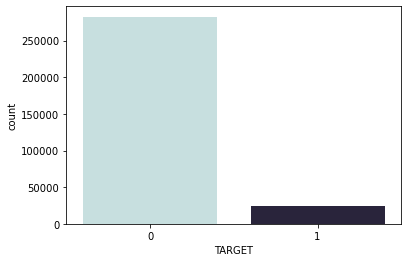

In [12]:
# plot target
sns.countplot(data=X_train, x="TARGET", palette="ch:start=.2,rot=-.3")

In [13]:
# dtype of features
X_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [14]:
# numbers of labels - categorical variables
X_train.select_dtypes(include=object).nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [15]:
# percentage missing data
missing_data = X_train.isna()
missing_data = missing_data.sum()/len(X_train)
missing_data = (missing_data.sort_values(ascending=False)[0:20]).map(lambda x:format(x,'.2%'))
pd.DataFrame(data=missing_data, columns=["perc_missing_data"])

,perc_missing_data
COMMONAREA_MEDI,69.87%
COMMONAREA_AVG,69.87%
COMMONAREA_MODE,69.87%
NONLIVINGAPARTMENTS_MODE,69.43%
NONLIVINGAPARTMENTS_AVG,69.43%
NONLIVINGAPARTMENTS_MEDI,69.43%
FONDKAPREMONT_MODE,68.39%
LIVINGAPARTMENTS_MODE,68.35%
LIVINGAPARTMENTS_AVG,68.35%
LIVINGAPARTMENTS_MEDI,68.35%


<u>**Analyzing distribution of variables**</u>

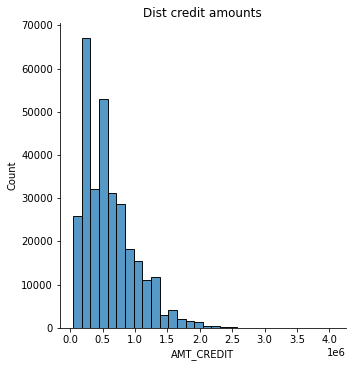

In [16]:
# plot distribution of "AMT CREDIT"
sns.displot(data=X_train, x="AMT_CREDIT",kind="hist", bins=30).set(
            title="Dist credit amounts"
            )
sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
plt.show()

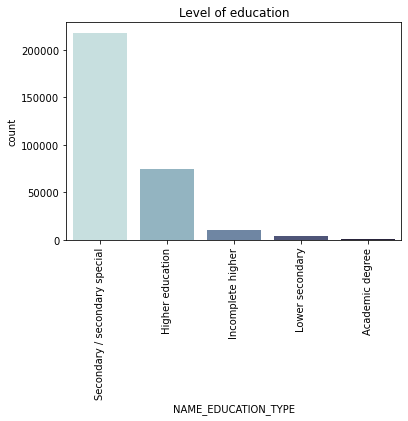

In [17]:
# plot education level
sns.countplot(data=X_train, x="NAME_EDUCATION_TYPE", palette="ch:start=.2,rot=-.3").set(
              title="Level of education"
              )
plt.xticks(rotation=90)
plt.show()

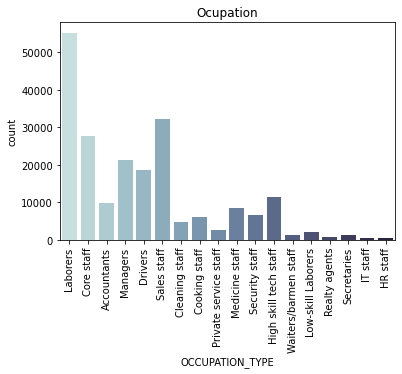

In [18]:
# plot distribution of ocupation
sns.countplot(data=X_train, x="OCCUPATION_TYPE", palette="ch:start=.2,rot=-.3").set(
              title="Ocupation"
              )
plt.xticks(rotation=90)
plt.show()

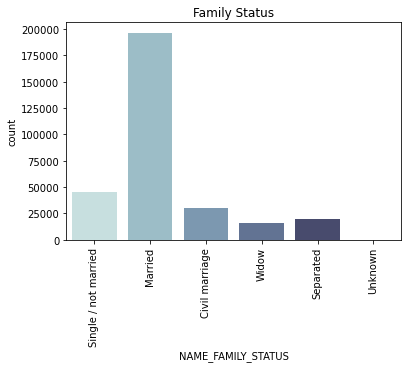

In [19]:
# plot family status
sns.countplot(data=X_train, x="NAME_FAMILY_STATUS", palette="ch:start=.2,rot=-.3").set(
            title="Family Status"
            )
plt.xticks(rotation=90)
plt.show()

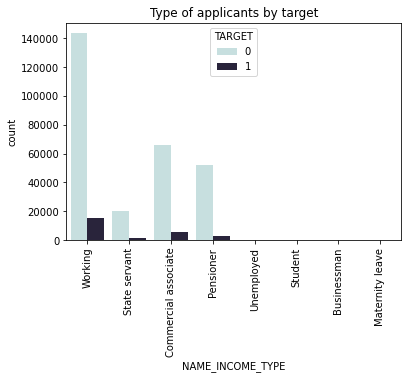

In [20]:
# plot type of applicants by target
sns.countplot(data=X_train, x="NAME_INCOME_TYPE", hue="TARGET", palette="ch:start=.2,rot=-.3").set(
             title="Type of applicants by target"
             )
plt.xticks(rotation=90)
plt.show()

## Preprocessing

In [21]:
# split train dataset & target 
y_train = X_train["TARGET"]
X_train = X_train.drop(columns=["TARGET","SK_ID_CURR"], axis=1)
X_test = X_test.drop(columns=["SK_ID_CURR"], axis=1)

In [22]:
def preprocessing(X_train, X_test):
    '''
    Preprocessing of the dataset train & test. 
    The function have differents parts with yours explanations
    
    Parameters:
    ----------
    X_train: part of the dataset to train the model without the target column
    
    X_test: part of the dataset to predict the model
    
    Returns:
    -------
    X_train & X_test as an array
    
    '''
       
# ====== Preprocessing numerical features to train & test

    '''
    Preprocessing numerical features to train & test dataset
    
    Outliers
    --------
    Delete outliers of the corresponding columns and 
    convert to the median
    
    Impute
    ------
    
    Impute the missing data of the numerical features with the median values
    of the train dataset
    
    '''

    # Outliers OWN_CAR_AGE: ID 271741 & 294131
    X_train["OWN_CAR_AGE"].mask(X_train["OWN_CAR_AGE"] == 91, X_train["OWN_CAR_AGE"].median(),
                                  inplace=True
                                 )
    X_test["OWN_CAR_AGE"].mask(X_test["OWN_CAR_AGE"] == 91, X_train["OWN_CAR_AGE"].median(),
                                  inplace=True
                                 )
    
    # Outliers DAYS_EMPLOYED > 0 convert to the median (365243)
    X_train["DAYS_EMPLOYED"].mask(X_train["DAYS_EMPLOYED"] > 0, X_train["DAYS_EMPLOYED"].median(),
                                  inplace=True
                                 )
    X_test["DAYS_EMPLOYED"].mask(X_test["DAYS_EMPLOYED"] > 0, X_train["DAYS_EMPLOYED"].median(),
                                  inplace=True
                                 )
    
    # Outliers AMT_INCOME_TOTAL == 117000000 convert to the median
    X_train["AMT_INCOME_TOTAL"].mask(X_train["AMT_INCOME_TOTAL"] == 117000000, 
                                     X_train["AMT_INCOME_TOTAL"].median(), inplace=True
                                 )
    X_test["AMT_INCOME_TOTAL"].mask(X_test["AMT_INCOME_TOTAL"] == 117000000, 
                                 X_train["AMT_INCOME_TOTAL"].median(), inplace=True
                               )
    
    
    # variables with numerical features train & test
    numeric_col_train = list(X_train.select_dtypes(exclude=object).columns)
    numeric_col_test = list(X_test.select_dtypes(exclude=object).columns)
    
   
    # Impute values for all columns with missing data with median   
    impute = SimpleImputer(strategy="median")
    X_train[numeric_col_train] = impute.fit_transform(X_train[numeric_col_train])
    X_test[numeric_col_test] = impute.transform(X_test[numeric_col_test])
    
    
# ====== Preprocessing categorical features to train & test

    '''
    Preprocessing categorical features to train & test dataset
    
    Outliers
    --------
    Delete outliers of the corresponding columns and 
    convert to the most frequent values
    
    Impute
    ------
    
    Impute the missing data of the categorical features with the most frequent
    of the train dataset
    
    '''

    # variables with categorical features train & test
    categ_col_train = list(X_train.select_dtypes(include=object).columns)
    categ_col_test = list(X_test.select_dtypes(include=object).columns)
    
    # impute nan values with the most frequent values
    impute = SimpleImputer(strategy='most_frequent')
    X_train[categ_col_train] = impute.fit_transform(X_train[categ_col_train])
    X_test[categ_col_test] = impute.transform(X_test[categ_col_test])
    
    '''
    Encode
    ------
    Categorical features with 2 o more categories
    
    Join
    ----
    The train & test dataset with all the corresponding
    new columns of the encode
    
    Drop
    ----
    The original columns of the train & test
    dataset
   
    ''' 
   
    # encoding categorical features with get dummies
    encode_train = pd.get_dummies(X_train[[ "NAME_CONTRACT_TYPE",
                                            "CODE_GENDER",     
                                            "FLAG_OWN_CAR",                   
                                            "FLAG_OWN_REALTY",                
                                            "NAME_TYPE_SUITE",                
                                            "NAME_INCOME_TYPE",               
                                            "NAME_EDUCATION_TYPE",            
                                            "NAME_FAMILY_STATUS",            
                                            "NAME_HOUSING_TYPE",              
                                            "OCCUPATION_TYPE",              
                                            "WEEKDAY_APPR_PROCESS_START",     
                                            "ORGANIZATION_TYPE",             
                                            "FONDKAPREMONT_MODE",             
                                            "HOUSETYPE_MODE",                
                                            "WALLSMATERIAL_MODE",             
                                            "EMERGENCYSTATE_MODE"
              ]], drop_first=True)
    
    encode_test = pd.get_dummies(X_train[[  "NAME_CONTRACT_TYPE",
                                            "CODE_GENDER",     
                                            "FLAG_OWN_CAR",                   
                                            "FLAG_OWN_REALTY",                
                                            "NAME_TYPE_SUITE",                
                                            "NAME_INCOME_TYPE",               
                                            "NAME_EDUCATION_TYPE",            
                                            "NAME_FAMILY_STATUS",            
                                            "NAME_HOUSING_TYPE",              
                                            "OCCUPATION_TYPE",              
                                            "WEEKDAY_APPR_PROCESS_START",     
                                            "ORGANIZATION_TYPE",             
                                            "FONDKAPREMONT_MODE",             
                                            "HOUSETYPE_MODE",                
                                            "WALLSMATERIAL_MODE",             
                                            "EMERGENCYSTATE_MODE"
              ]], drop_first=True)
    
    # join the X_train & X_test with the encode_test & encode_train
    X_train = X_train.join(encode_train)
    X_test = X_test.join(encode_test)
    
    # drop the original columns on train & test
    X_train.drop(X_train.select_dtypes(include=object).columns, axis=1, inplace=True)
    X_test.drop(X_test.select_dtypes(include=object).columns, axis=1, inplace=True)
    
    '''
    Scaling
    -------
    Scale numerical features with StandarScaler
    
    '''
    
    # Features Scaling
    columns = list(X_train.select_dtypes(exclude=object).columns)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[columns])
    X_test_scaled = scaler.transform(X_test[columns])
    
    return np.array(X_train), np.array(X_test)

In [23]:
X_train, X_test = preprocessing(X_train, X_test)

## Training Models

### Baseline: LogisticRegression

In [24]:
# fit Logistic Regression model
baseline = LogisticRegression()
baseline.fit(X_train, y_train)

LogisticRegression()

In [25]:
# predict Logistic Regression model
predict_baseline = baseline.predict_proba(X_test)[:,1]
df_predict = pd.DataFrame(predict_baseline, columns=["TARGET"])

# join ID with the predict to upload to Kaggle 
id_curr = test[["SK_ID_CURR"]].astype(int)
baseline_kaggle = id_curr.join(df_predict)

# save to csv file the dataframe with the predict of the Logistic Regression model
baseline_kaggle.to_csv("baseline_kaggle.csv", index=False)

**<font color= CD5C5C> <u>Kaggle Score:<u>**

**<font color= CD5C5C> Score: 0.62159**

**<font color= CD5C5C>Public score: 0.63403**


### Training a Random Forest Classifier 

In [26]:
# fit Random Forest model
forest = RandomForestClassifier(n_jobs=-1, random_state=1)

# print the time taken by the fit function
start= time.time()
forest.fit(X_train, y_train)
end = time.time()
print({end - start})

{172.83430314064026}


In [27]:
# predict Random Forest model
forest_predict = forest.predict_proba(X_test)[:,1]

# join ID with the predict to upload to Kaggle
df_forest = pd.DataFrame(forest_predict, columns=["TARGET"])
forest_kaggle = id_curr.join(df_forest)

# save to csv file the dataframe with the predict of the Random Forest model
forest_kaggle.to_csv("forest_kaggle.csv", index=False)

**<font color= CD5C5C> <u>Kaggle Score:<u>**
    
**<font color= CD5C5C> Score: 0.67020**
    
**<font color= CD5C5C> Public score: 0.67445**
    

### Randomized Search with Cross Validation

In [28]:
# differents hyperparameters to train Random Forest
hyperparameter_grid = {
 'bootstrap': [True, False],
 'max_depth': [100, None],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [2, 5],
 'n_estimators': [100, 200]
}

In [29]:
# train Random Forest with differents hyperparameters to find
# the best combination and print the time taken by the fit function
start= time.time()
best_hyper = RandomizedSearchCV(forest, hyperparameter_grid , scoring="roc_auc", cv=3)
best_hyper.fit(X_train, y_train)
end = time.time()
print({end - start})
print(f"{best_hyper}")

{7844.553683996201}
RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [100, None],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   scoring='roc_auc')


In [30]:
# predict Random Forest model with the best hyperparameters
forest_predict_hyper = best_hyper.predict_proba(X_test)[:,1]

# join ID with the predict to upload to Kaggle
df_forest_hyper = pd.DataFrame(forest_predict_hyper, columns=["TARGET"])
forest_hyper_kaggle = id_curr.join(df_forest_hyper)

# save to csv file the dataframe with the predict of the Random Forest model
forest_hyper_kaggle.to_csv("forest_hyper_kaggle.csv", index=False)

**<font color= CD5C5C> <u>Kaggle Score:<u>**
    
**<font color= CD5C5C>Score: 0.69434**
    
**<font color= CD5C5C>Public score: 0.70191**

### Training a LightGBM model 

In [31]:
# train XGB model with parameters for default
model_xgb = XGBClassifier(random_state=2)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=2,
              reg_alpha=0, reg_lambda=1, ...)

In [34]:
# predict XGB model
predict_xgb = model_xgb.predict_proba(X_test)

# join ID with the predict to upload to Kaggle
df_xgb = pd.DataFrame(predict_xgb[:,1], columns=["TARGET"])
df_xgb = id_curr.join(df_xgb)

# save to csv file the dataframe with the predict of the XGB model
df_xgb.to_csv("df_lgb.csv", index=False)

**<font color= CD5C5C> <u>Kaggle Score:<u>**
    
**<font color= CD5C5C> Score: 0.71318**
    
**<font color= CD5C5C> Public score: 0.71516**

In [35]:
# train LGBM model with parameters for default
model_gbm = lgb.LGBMClassifier(random_state=2)
model_gbm.fit(X_train, y_train)

LGBMClassifier(random_state=2)

In [36]:
# predict LightGBM model
predict_gbm = model_gbm.predict_proba(X_test)

# join ID with the predict to upload to Kaggle
df_gbm = pd.DataFrame(predict_gbm[:,1], columns=["TARGET"])
df_gbm = id_curr.join(df_gbm)

# save to csv file the dataframe with the predict of the LightGBM model
df_gbm.to_csv("df_gbm.csv", index=False)

**<font color= CD5C5C> <u>Kaggle Score:<u>**
    
**<font color= CD5C5C> Score: 0.72161**
    
**<font color= CD5C5C> Public score: 0.72467**

In [37]:
# train LGBM model with differents hyperparameters
model2_gbm = lgb.LGBMClassifier(n_estimators=200, subsample_for_bin=300000, random_state=2)
model2_gbm.fit(X_train, y_train)

LGBMClassifier(n_estimators=200, random_state=2, subsample_for_bin=300000)

In [38]:
# predict LightGBM model with differents hyperparameters
predict_gbm2 = model2_gbm.predict_proba(X_test)

# join ID with the predict to upload to Kaggle differents hyperparameters
df_gbm2 = pd.DataFrame(predict_gbm2[:,1], columns=["TARGET"])
df_gbm2 = id_curr.join(df_gbm2)

# save to csv file the dataframe with the predict of the LightGBM model 
# differents hyperparameters
df_gbm2.to_csv("df_gbm2.csv", index=False)

**<font color= CD5C5C> <u>Kaggle Score:<u>**

**<font color= CD5C5C> Score: 0.72192**
    
**<font color= CD5C5C> Public score: 0.71892**

### Using Scikit Learn Pipelines 

In [39]:
y_train_pip = train["TARGET"].copy()
X_train_pip = train.drop(columns=["TARGET","SK_ID_CURR"], axis=1).copy()
X_test_pip = test.drop(columns=["SK_ID_CURR"], axis=1).copy()

In [40]:
numeric_features = X_train_pip.select_dtypes(exclude=object).columns.tolist()
categorical_features = X_train_pip.select_dtypes(include=object).columns.tolist()

In [41]:
# Pipeline for numeric features
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
    ])

In [42]:
# Pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('scale', StandardScaler())
    ])

In [43]:
# preprocessing numeric and categorical features
preprocessing = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numeric_features),
    ('categorical', categorical_pipeline, categorical_features)
])

In [44]:
# linear regression model
lr_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('model_lg', LogisticRegression())
])

In [45]:
# fit model
lr_pipeline.fit(X_train_pip, y_train_pip)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTR

In [46]:
# pipeline predict
predict_pipe = lr_pipeline.predict_proba(X_test_pip)

In [47]:
# join ID with the predict to upload to Kaggle
df_pipe = pd.DataFrame(predict_pipe[:,1], columns=["TARGET"])
df_pipe = id_curr.join(df_pipe)

# save to csv file the dataframe with the predict of the LightGBM model
df_pipe.to_csv("df_pipe.csv", index=False)

**<font color= CD5C5C> <u>Kaggle Score:<u>**
    
**<font color= CD5C5C>Score: 0.73330**
    
**<font color= CD5C5C>Public score: 0.73951**